In [ ]:
import dill
dill.load_session('Sentiment Analysis.db')

In [1]:
import pandas as pd 
import numpy as np
import itertools
import re
import string
pd.set_option('display.max_colwidth', 100)
import nltk.corpus
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
#!pip install contractions
import contractions 
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix,precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#!pip install xgboost
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import dill

In [2]:
reviews = pd.read_json(r'C:\Users\dfota\OneDrive\Έγγραφα\Thesis Project\Amazon-Game-Reviews-Analysis\Data\MergedDataset.json')

In [3]:
reviews.head()

,asin,overall,reviewTime,title,category,imageURLHighRes,reviews
0,B00000DMAN,5,"11 28, 1999",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This game is a lot of fun, with a creepy atmosphere that revolves around the disappearance of Ag..."
1,B00000DMAN,4,"03 5, 2003",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was not the best mystery/adventure game I've ever played, and I'm not even a big fan of suc..."
2,B00000DMAN,4,"02 13, 2001",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was a pretty good game, but not a great game. I'd probably rate this closer to 3 1/2 stars...."
3,B00000DMAN,4,"08 19, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,We stopped watching the series (lack of time) and so this was a nice way to keep the excitement...
4,B00000DMAN,5,"07 27, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"As a fan of Myst and Riven, I would not put this game in the same category. However, it does e..."


In [4]:
reviews['rating_class'] = reviews['overall'].apply(lambda x: 'bad' if x < 3 else'good')
reviews.head()

,asin,overall,reviewTime,title,category,imageURLHighRes,reviews,rating_class
0,B00000DMAN,5,"11 28, 1999",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This game is a lot of fun, with a creepy atmosphere that revolves around the disappearance of Ag...",good
1,B00000DMAN,4,"03 5, 2003",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was not the best mystery/adventure game I've ever played, and I'm not even a big fan of suc...",good
2,B00000DMAN,4,"02 13, 2001",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was a pretty good game, but not a great game. I'd probably rate this closer to 3 1/2 stars....",good
3,B00000DMAN,4,"08 19, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,We stopped watching the series (lack of time) and so this was a nice way to keep the excitement...,good
4,B00000DMAN,5,"07 27, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"As a fan of Myst and Riven, I would not put this game in the same category. However, it does e...",good


In [5]:
reviews.shape

(111582, 8)

In [6]:
sample, df_drop_it = train_test_split(reviews, train_size =0.15, stratify=reviews['rating_class'])

In [7]:
sample.category.value_counts(normalize=True)

Playstation    0.387166
Xbox           0.338591
PC             0.274243
Name: category, dtype: float64

In [8]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16737 entries, 8013 to 67720
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   asin             16737 non-null  object
 1   overall          16737 non-null  int64 
 2   reviewTime       16737 non-null  object
 3   title            16737 non-null  object
 4   category         16737 non-null  object
 5   imageURLHighRes  16289 non-null  object
 6   reviews          16737 non-null  object
 7   rating_class     16737 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.1+ MB


In [9]:
sample.shape

(16737, 8)

In [10]:
sample.rating_class.value_counts(normalize=True)

good    0.856067
bad     0.143933
Name: rating_class, dtype: float64

In [11]:
raw_tokens=len([w for t in (sample["reviews"].apply(word_tokenize)) for w in t])
print('Number of raw tokens: {}'.format(raw_tokens))

Number of raw tokens: 3200577


In [12]:
def text_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

In [14]:
def replace_numbers(text):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [15]:
stopword_list= stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [16]:
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

In [17]:
def lemmatize_text(words):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in words]

In [18]:
def normalize_and_lemmatize(input):
    sample = text_cleaning(input)
    sample = expand_contractions(sample)
    words = nltk.word_tokenize(sample)
    words = remove_stopwords(words)    
    lemmas = lemmatize_text(words)
    return ' '.join(lemmas)

In [19]:
sample['clean_text'] = sample['reviews'].map(lambda text: normalize_and_lemmatize(text))

In [20]:
clean_tokens=len([w for t in (sample["clean_text"].apply(word_tokenize)) for w in t])
print('Number of clean tokens: {}\n'.format(clean_tokens))
print('Percentage of removed tokens: {0:.2f}'.format(1-(clean_tokens/raw_tokens)))

Number of clean tokens: 1410568

Percentage of removed tokens: 0.56


In [21]:
def token (text):
    token = [w for w in nltk.word_tokenize(text)]
    return token

sample['token'] = sample['clean_text'].apply(token)

In [22]:
sample.head()

,asin,overall,reviewTime,title,category,imageURLHighRes,reviews,rating_class,clean_text,token
8013,B0001XOJAS,2,"05 14, 2005",Empire Earth 2 - PC,PC,https://images-na.ssl-images-amazon.com/images/I/31A89D8TMDL.jpg,What a dud. Love Empire Earth. Still play it. EE2... Doesn't even come close. More like rise of ...,bad,dud love empire earth still play not even come close like rise nation hate toothey not even incl...,"[dud, love, empire, earth, still, play, not, even, come, close, like, rise, nation, hate, toothe..."
32181,B000HWX418,4,"08 29, 2010",The Darkness - Playstation 3,Playstation,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,I picked this up for around ten dollars and figured that it would be just an ok game. It actuall...,good,picked around ten dollar figured would ok game actually lot fun cool graphic good horror theme t...,"[picked, around, ten, dollar, figured, would, ok, game, actually, lot, fun, cool, graphic, good,..."
37017,B000ZK695U,5,"12 28, 2014",White Knight Chronicles International Edition - Playstation 3,Playstation,https://images-na.ssl-images-amazon.com/images/I/513ZWdgsTyL.jpg,"The game was great, and the seller sent it out fast, however the gripe is with the developers an...",good,game great seller sent fast however gripe developer psn shutting white knight chronicle server i...,"[game, great, seller, sent, fast, however, gripe, developer, psn, shutting, white, knight, chron..."
13441,B000U88UVS,2,"09 5, 2009",SimCity Societies - PC,PC,https://images-na.ssl-images-amazon.com/images/I/51eQAgAaTzL.jpg,I thought there might be more to this than previous Sim City games. Ultimately it is more of the...,bad,thought might previous sim city game ultimately make fun experience wanted like guess need sandb...,"[thought, might, previous, sim, city, game, ultimately, make, fun, experience, wanted, like, gue..."
5871,B00006GEX2,1,"01 3, 2003",Age of Mythology - PC,PC,https://images-na.ssl-images-amazon.com/images/I/5196WKNJGEL.jpg,"Beware: This program, like many other recent games, will ONLY run on an account that has adminis...",bad,beware program like many recent game run account administrator privilege window xp mean common h...,"[beware, program, like, many, recent, game, run, account, administrator, privilege, window, xp, ..."


In [23]:
sample['rating_class'] = sample['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [24]:
X = sample['clean_text']
y = sample['rating_class']

In [25]:
#!pip install sklearn

# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(12552,)
Test Set Shape		:(4185,)


In [27]:
#Function to create a confusion matrix plot for 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [140]:
#Display confusion matrix for selected model with countVectorizer  
def disp_confusion_matrix(y_pred, model_name, vector = 'CountVectorizer'):
   
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

In [29]:
def plot_auroc_curve(test_y, prob_pred):
  fpr, tpr, thresh = {}, {}, {}
  n_class = 2
  print(test_y)
  print(prob_pred)
  for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, prob_pred[:, i], pos_label=i)
  
  plt.figure(figsize =(12, 8))
  plt.plot(fpr[0], tpr[0], linestyle='--', color='orange', label='class0')
  plt.plot(fpr[1], tpr[1], linestyle='--', color='green', label='class1')
  plt.plot([0, 1], [0, 1], 'k-', alpha=0.75)
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')

In [30]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1), max_features=10000)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [31]:
y_test.shape

(4185,)

In [32]:
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 10000


In [33]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [34]:
pd.DataFrame(count_vect_train, columns = vocab)

,aa,aaa,abandon,abandoned,abandoning,ability,abit,able,aboard,abound,...,zillion,zip,zombie,zombielike,zombrex,zone,zoo,zoom,zoomed,zooming
0,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    global model
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score)) 

In [36]:
clf = DummyClassifier(strategy = 'stratified', random_state =42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

f1 score: 0.7567043786300403


In [37]:
# Compute and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       601
           1       0.86      0.86      0.86      3584

    accuracy                           0.76      4185
   macro avg       0.50      0.50      0.50      4185
weighted avg       0.76      0.76      0.76      4185



In [38]:
modellr = LogisticRegression()
parameterslr = {
    'penalty' : ['l2'], 
    'C'       : [0.1, 1, 10, 100],
    'solver'  : ['newton-cg', 'sag', 'saga'],
    'max_iter' : [3000, 4000, 5000]
}

In [39]:
grid_search_logreg = RandomizedSearchCV(modellr,parameterslr,verbose = 2, n_iter=10, n_jobs = -1, 
                          scoring='f1',error_score=0)
grid_result_logreg = grid_search_logreg.fit(count_vect_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [41]:
grid_result_logreg.best_params_

{'solver': 'saga', 'penalty': 'l2', 'max_iter': 3000, 'C': 10}

In [42]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(solver = 'saga', verbose = 2, penalty = 'l2', max_iter = 3000,
                                     class_weight = 'balanced', C = 10, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 1962 epochs took 2752 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 45.9min finished


f1 score: 0.8947493537605482


In [43]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.58      0.78      0.67       601
           1       0.96      0.91      0.93      3584

    accuracy                           0.89      4185
   macro avg       0.77      0.84      0.80      4185
weighted avg       0.91      0.89      0.89      4185



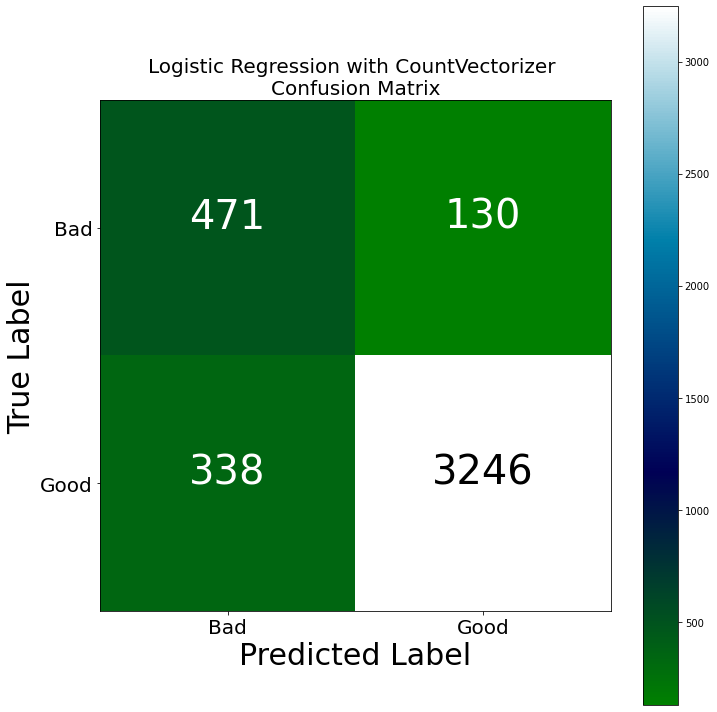

In [141]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

In [45]:
y_pred_proba = model.predict_proba(count_vect_test)
y_pred_proba

array([[0.26021544, 0.73978456],
       [0.60055994, 0.39944006],
       [0.39365097, 0.60634903],
       ...,
       [0.98748607, 0.01251393],
       [0.16865654, 0.83134346],
       [0.14984098, 0.85015902]])

74603    1
86839    1
44383    1
25730    0
52972    1
        ..
94446    1
62012    1
78272    1
97108    1
84153    1
Name: rating_class, Length: 4185, dtype: int64
[[0.26021544 0.73978456]
 [0.60055994 0.39944006]
 [0.39365097 0.60634903]
 ...
 [0.98748607 0.01251393]
 [0.16865654 0.83134346]
 [0.14984098 0.85015902]]


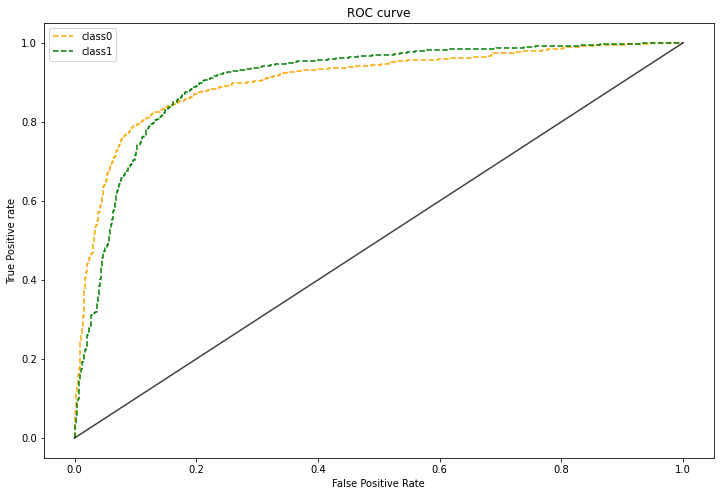

In [46]:
plot_auroc_curve(y_test, y_pred_proba)
# model, count_vect_test, y_test

In [48]:
modelrf = RandomForestClassifier()
parametersrf = {
    'n_estimators'  : [10, 100, 1000],
    'max_features': ['auto', 'log2'],
    'max_depth': [5, 10, None]
}

In [49]:
grid_search = RandomizedSearchCV(modelrf,parametersrf,verbose = 2, n_iter=10, n_jobs = -1, 
                          scoring='f1',error_score=0)

In [50]:
grid_result = grid_search.fit(count_vect_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [51]:
grid_result.best_params_

{'n_estimators': 100, 'max_features': 'auto', 'max_depth': None}

In [52]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 100, max_features='auto', max_depth=None, verbose=3, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


f1 score: 0.850285369817497


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [55]:
y_pred_proba = model.predict_proba(count_vect_test)
y_pred_proba

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


array([[0.09, 0.91],
       [0.35, 0.65],
       [0.  , 1.  ],
       ...,
       [0.23, 0.77],
       [0.  , 1.  ],
       [0.33, 0.67]])

74603    1
86839    1
44383    1
25730    0
52972    1
        ..
94446    1
62012    1
78272    1
97108    1
84153    1
Name: rating_class, Length: 4185, dtype: int64
[[0.09 0.91]
 [0.35 0.65]
 [0.   1.  ]
 ...
 [0.23 0.77]
 [0.   1.  ]
 [0.33 0.67]]


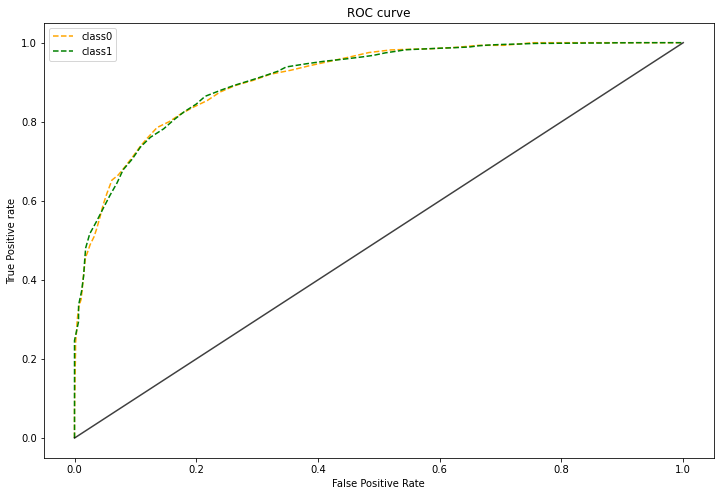

In [56]:
plot_auroc_curve(y_test, y_pred_proba)

In [57]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.96      0.20      0.34       601
           1       0.88      1.00      0.94      3584

    accuracy                           0.88      4185
   macro avg       0.92      0.60      0.64      4185
weighted avg       0.89      0.88      0.85      4185



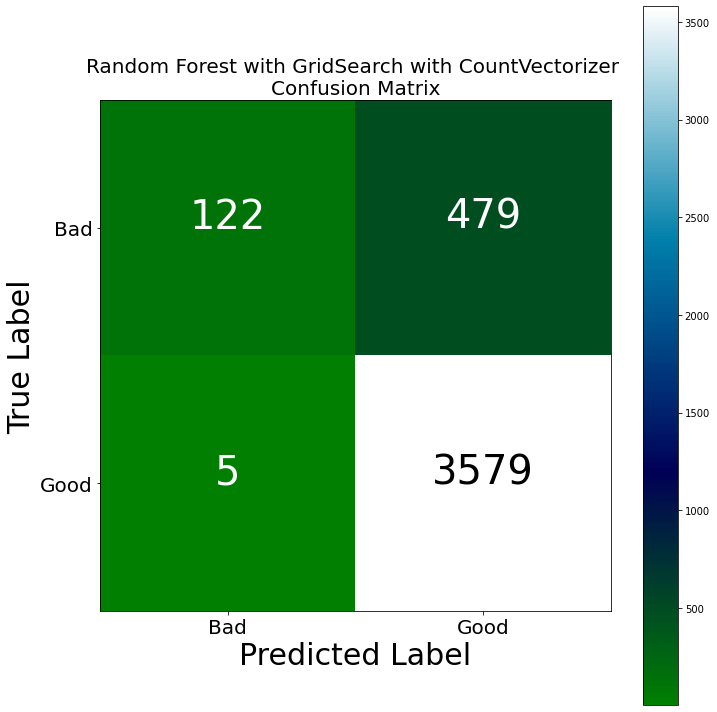

In [143]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest with GridSearch")

In [59]:
modelnb = MultinomialNB()
parametersnb = {
    'alpha'  : [0.1, 1, 10, 100]
}

In [60]:
grid_search = RandomizedSearchCV(modelnb,parametersnb,verbose = 2, n_iter=10, n_jobs = -1, 
                          scoring='f1',error_score=0)

In [61]:
grid_result = grid_search.fit(count_vect_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [62]:
grid_result.best_params_

{'alpha': 1}

In [77]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB(alpha=1))

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.8968455243271366


In [64]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       601
           1       0.94      0.94      0.94      3584

    accuracy                           0.90      4185
   macro avg       0.79      0.79      0.79      4185
weighted avg       0.90      0.90      0.90      4185



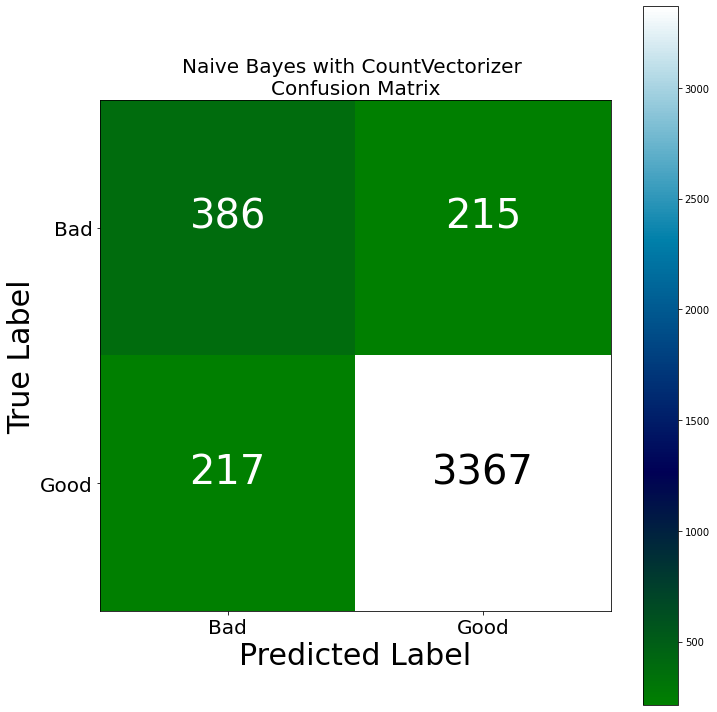

In [144]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

In [79]:
y_pred_proba = model.predict_proba(count_vect_test)
y_pred_proba

array([[1.83359272e-01, 8.16640728e-01],
       [5.05219947e-04, 9.99494780e-01],
       [1.97010007e-02, 9.80298999e-01],
       ...,
       [9.99999996e-01, 4.10161143e-09],
       [3.78065121e-02, 9.62193488e-01],
       [2.16974913e-04, 9.99783025e-01]])

74603    1
86839    1
44383    1
25730    0
52972    1
        ..
94446    1
62012    1
78272    1
97108    1
84153    1
Name: rating_class, Length: 4185, dtype: int64
[[1.83359272e-01 8.16640728e-01]
 [5.05219947e-04 9.99494780e-01]
 [1.97010007e-02 9.80298999e-01]
 ...
 [9.99999996e-01 4.10161143e-09]
 [3.78065121e-02 9.62193488e-01]
 [2.16974913e-04 9.99783025e-01]]


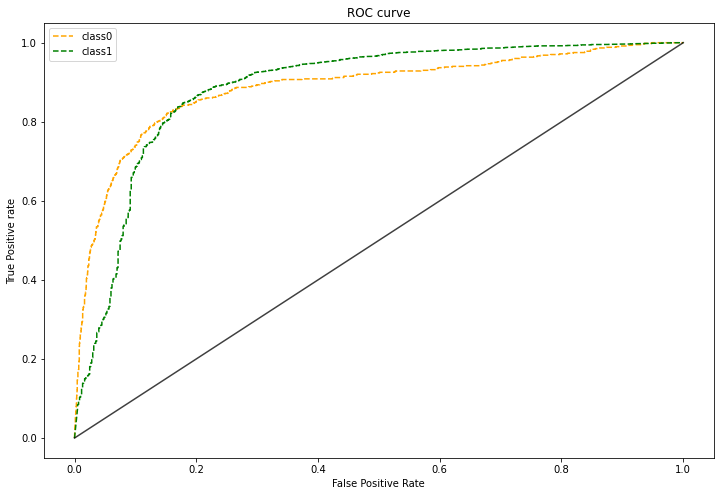

In [80]:
plot_auroc_curve(y_test, y_pred_proba)

In [66]:
parametersxgb = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              "n_estimators":[100]}

In [67]:
modelxgb = XGBClassifier(n_estimators=100, n_jobs=-1)

In [68]:
grid_search = RandomizedSearchCV(modelxgb,parametersxgb,verbose = 2, n_iter=10, n_jobs = -1, 
                          scoring='f1',error_score=0)

In [69]:
grid_result = grid_search.fit(count_vect_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[23:37:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [70]:
grid_result.best_params_

{'subsample': 0.5,
 'n_estimators': 100,
 'min_child_weight': 5,
 'max_depth': 12,
 'learning_rate': 0.1,
 'colsample_bytree': 0.75}

In [71]:
modeling(XGBClassifier(subsample=0.5, n_estimators=100, min_child_weight=5, max_depth=12, learning_rate=0.1,
 colsample_bytree=0.75))

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

[09:33:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.8966182312763366


In [72]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.83      0.46      0.59       601
           1       0.92      0.98      0.95      3584

    accuracy                           0.91      4185
   macro avg       0.87      0.72      0.77      4185
weighted avg       0.90      0.91      0.90      4185



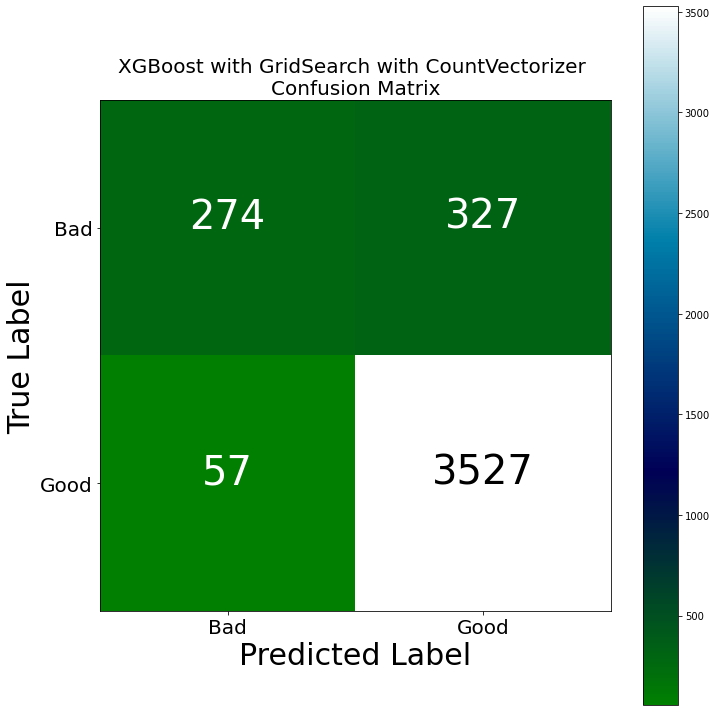

In [145]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost with GridSearch")

In [75]:
y_pred_proba = model.predict_proba(count_vect_test)
y_pred_proba

array([[0.040824  , 0.959176  ],
       [0.29589885, 0.70410115],
       [0.05708247, 0.9429175 ],
       ...,
       [0.07513905, 0.92486095],
       [0.02092135, 0.97907865],
       [0.2253915 , 0.7746085 ]], dtype=float32)

74603    1
86839    1
44383    1
25730    0
52972    1
        ..
94446    1
62012    1
78272    1
97108    1
84153    1
Name: rating_class, Length: 4185, dtype: int64
[[0.040824   0.959176  ]
 [0.29589885 0.70410115]
 [0.05708247 0.9429175 ]
 ...
 [0.07513905 0.92486095]
 [0.02092135 0.97907865]
 [0.2253915  0.7746085 ]]


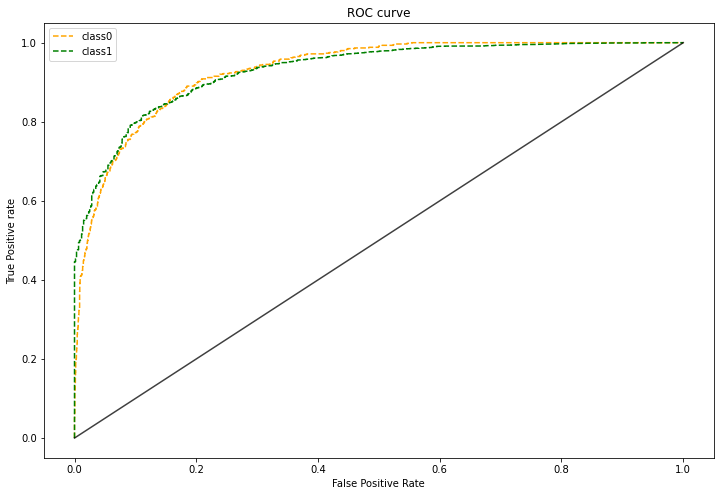

In [76]:
plot_auroc_curve(y_test, y_pred_proba)

In [81]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

In [82]:
# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [151]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'TF - IDF'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

In [84]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

In [85]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost'])

In [86]:
df_tv2

precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.888172 bad       0.582200  0.783694  0.668085   
                                  good      0.961493  0.905692  0.932759   
                                  average   0.907023  0.888172  0.894749   
           Random Forest 0.884349 bad       0.960630  0.202995  0.335165   
                                  good      0.881962  0.998605  0.936666   
                                  average   0.893259  0.884349  0.850285   
           Naive Bayes   0.896774 bad       0.640133  0.642263  0.641196   
                                  good      0.939978  0.939453  0.939715   
                                  average   0.896917  0.896774  0.896846   
           XGBoost       0.908244 bad       0.827795  0.455907  0.587983   
                                  good      0.915153  0.984096  0.948373   
                                  average   0.902608  0.908244  0.896618   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.888172 bad        601.0  
                                  good      3584.0  
                                  average   4185.0  
           Random Forest 0.884349 bad        601.0  
                                  good      3584.0  
                                  average   4185.0  
           Naive Bayes   0.896774 bad        601.0  
                                  good      3584.0  
                                  average   4185.0  
           XGBoost       0.908244 bad        601.0  
                                  good      3584.0  
                                  average   4185.0

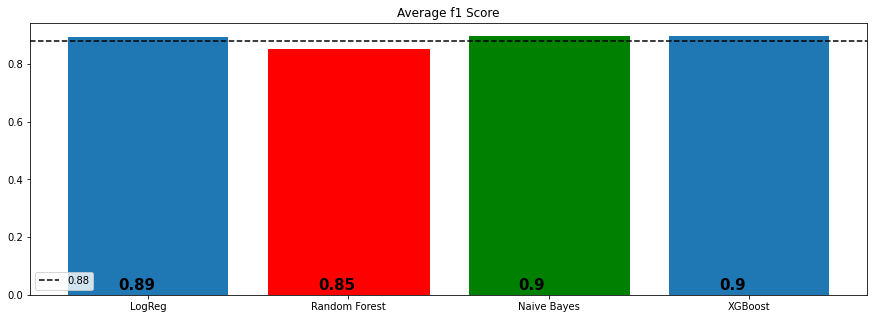

In [87]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average f1 Score")

In [88]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), max_features=10000)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

In [91]:
grid_search_logreg = RandomizedSearchCV(modellr,parameterslr,verbose = 2, n_iter=10, n_jobs = -1, 
                          scoring='f1',error_score=0)
grid_result_logreg = grid_search_logreg.fit(tfidf_vect_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [92]:
grid_result_logreg.best_params_

{'solver': 'sag', 'penalty': 'l2', 'max_iter': 4000, 'C': 10}

In [107]:
# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(solver = 'sag', 
                            class_weight = 'balanced', C = 10, n_jobs = -1, 
                            penalty = 'l2', max_iter = 4000, verbose = 2, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 3635 seconds
f1 score: 0.8958497807904654


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 60.6min finished


In [108]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.59      0.76      0.66       601
           1       0.96      0.91      0.93      3584

    accuracy                           0.89      4185
   macro avg       0.78      0.83      0.80      4185
weighted avg       0.90      0.89      0.90      4185



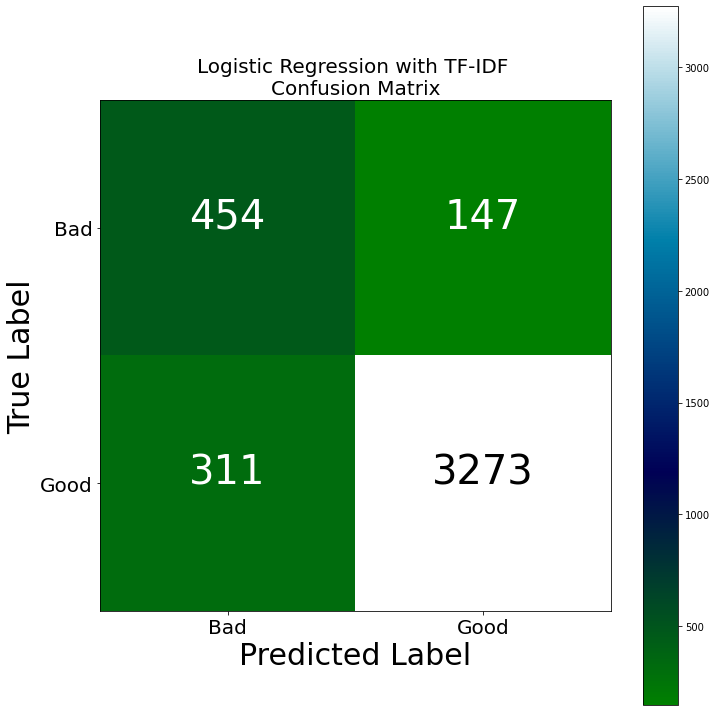

In [109]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

In [110]:
y_pred_proba = model.predict_proba(tfidf_vect_test)
y_pred_proba

array([[1.47606787e-01, 8.52393213e-01],
       [4.26491851e-01, 5.73508149e-01],
       [7.84471334e-02, 9.21552867e-01],
       ...,
       [7.78853653e-01, 2.21146347e-01],
       [1.72938667e-05, 9.99982706e-01],
       [3.14661998e-01, 6.85338002e-01]])

74603    1
86839    1
44383    1
25730    0
52972    1
        ..
94446    1
62012    1
78272    1
97108    1
84153    1
Name: rating_class, Length: 4185, dtype: int64
[[1.47606787e-01 8.52393213e-01]
 [4.26491851e-01 5.73508149e-01]
 [7.84471334e-02 9.21552867e-01]
 ...
 [7.78853653e-01 2.21146347e-01]
 [1.72938667e-05 9.99982706e-01]
 [3.14661998e-01 6.85338002e-01]]


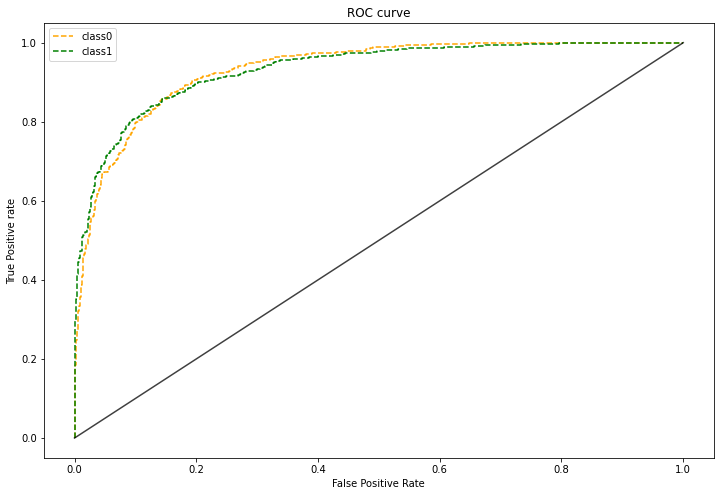

In [111]:
plot_auroc_curve(y_test, y_pred_proba)

In [99]:
grid_search_rf_tfidf = RandomizedSearchCV(modelrf,parametersrf,verbose = 2, n_iter=10, n_jobs = -1, 
                          scoring='f1',error_score=0)
grid_result_rf_tfidf = grid_search_rf_tfidf.fit(tfidf_vect_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [100]:
grid_result_rf_tfidf.best_params_

{'n_estimators': 10, 'max_features': 'auto', 'max_depth': None}

In [101]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 10, max_features='auto', max_depth=None, verbose=3, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.5s finished


f1 score: 0.862632686779185


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [102]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       0.77      0.29      0.42       601
           1       0.89      0.99      0.94      3584

    accuracy                           0.89      4185
   macro avg       0.83      0.64      0.68      4185
weighted avg       0.88      0.89      0.86      4185



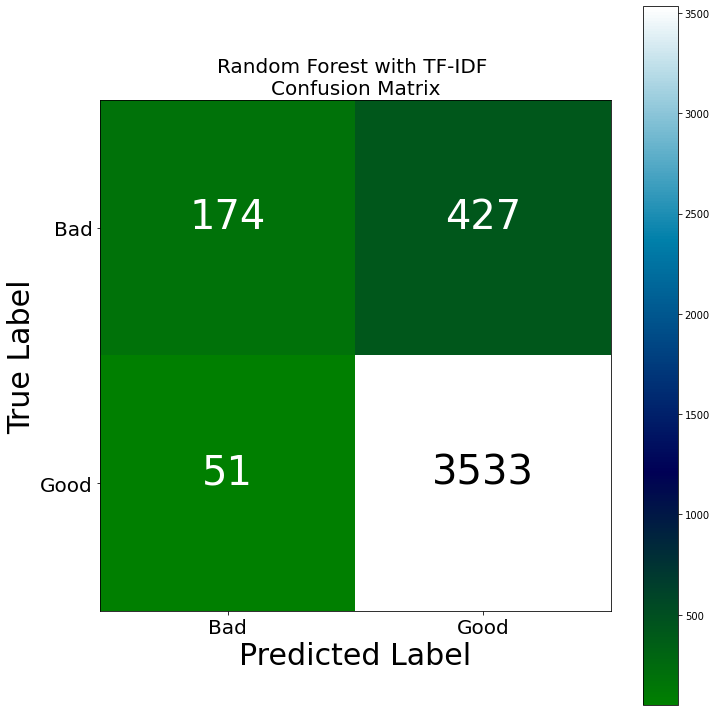

In [103]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

In [105]:
y_pred_proba = model.predict_proba(tfidf_vect_test)
y_pred_proba

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([[0. , 1. ],
       [0.4, 0.6],
       [0. , 1. ],
       ...,
       [0.2, 0.8],
       [0. , 1. ],
       [0.2, 0.8]])

74603    1
86839    1
44383    1
25730    0
52972    1
        ..
94446    1
62012    1
78272    1
97108    1
84153    1
Name: rating_class, Length: 4185, dtype: int64
[[0.  1. ]
 [0.4 0.6]
 [0.  1. ]
 ...
 [0.2 0.8]
 [0.  1. ]
 [0.2 0.8]]


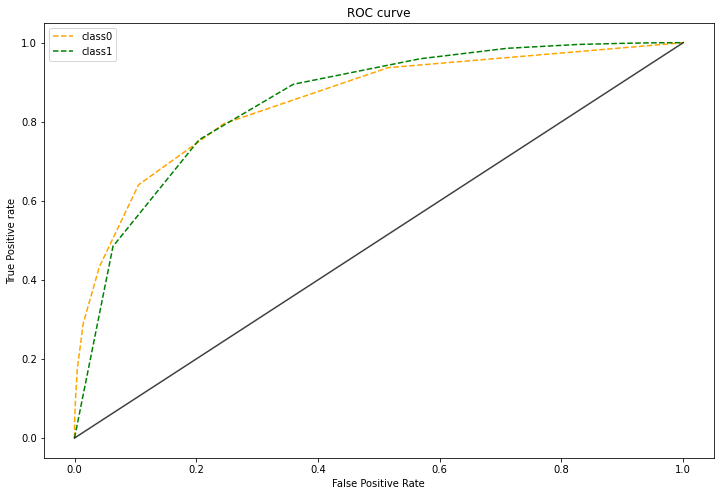

In [106]:
plot_auroc_curve(y_test, y_pred_proba)

In [115]:
grid_search_nb_tfidf = RandomizedSearchCV(modelnb,parametersnb,verbose = 2, n_iter=10, n_jobs = -1, 
                          scoring='f1',error_score=0)
grid_result_nb_tfidf = grid_search_nb_tfidf.fit(tfidf_vect_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [116]:
grid_result_nb_tfidf.best_params_

{'alpha': 0.1}

In [117]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(alpha = 0.1), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.8459547813411437


In [118]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.91      0.19      0.32       601
           1       0.88      1.00      0.93      3584

    accuracy                           0.88      4185
   macro avg       0.89      0.59      0.63      4185
weighted avg       0.88      0.88      0.85      4185



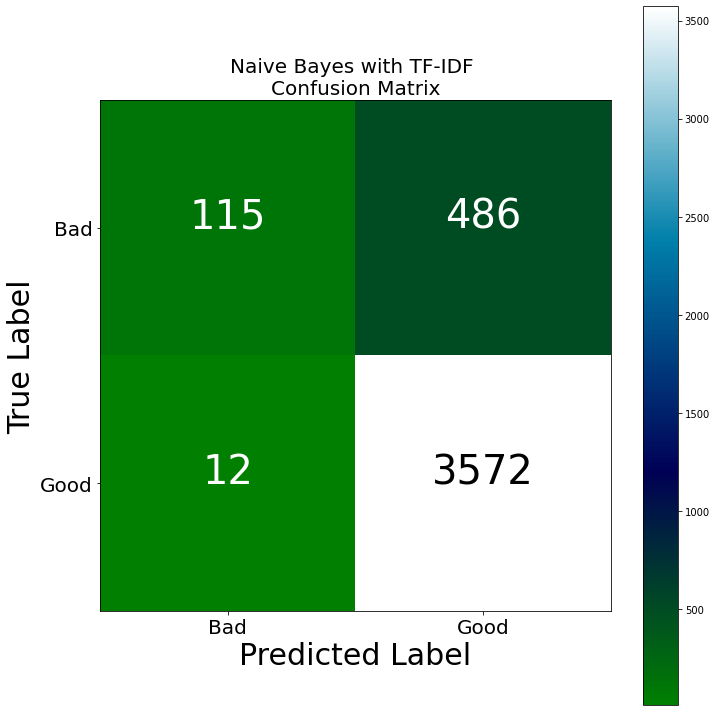

In [119]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

In [120]:
y_pred_proba = model.predict_proba(tfidf_vect_test)
y_pred_proba

array([[0.12761559, 0.87238441],
       [0.11586898, 0.88413102],
       [0.03259399, 0.96740601],
       ...,
       [0.47951759, 0.52048241],
       [0.02324774, 0.97675226],
       [0.14844052, 0.85155948]])

74603    1
86839    1
44383    1
25730    0
52972    1
        ..
94446    1
62012    1
78272    1
97108    1
84153    1
Name: rating_class, Length: 4185, dtype: int64
[[0.12761559 0.87238441]
 [0.11586898 0.88413102]
 [0.03259399 0.96740601]
 ...
 [0.47951759 0.52048241]
 [0.02324774 0.97675226]
 [0.14844052 0.85155948]]


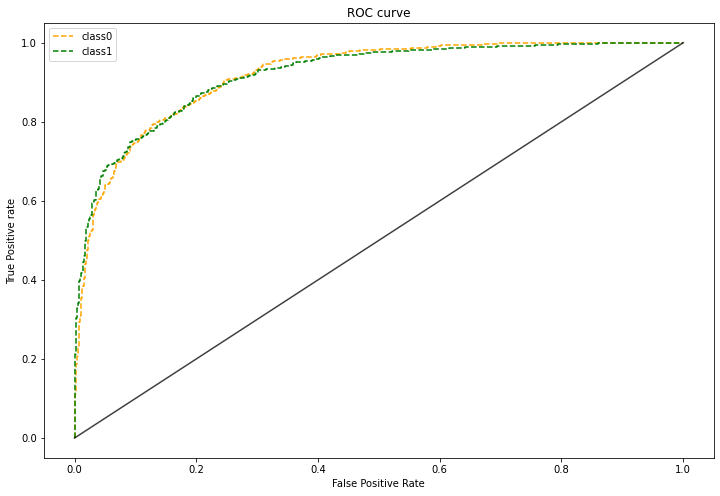

In [121]:
plot_auroc_curve(y_test, y_pred_proba)

In [124]:
grid_search_xgb_tfidf = RandomizedSearchCV(modelxgb,parametersxgb,verbose = 2, n_iter=10, n_jobs = -1, 
                          scoring='f1',error_score=0)
grid_result_xgb_tfidf = grid_search_xgb_tfidf.fit(tfidf_vect_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[19:36:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [125]:
grid_result_xgb_tfidf.best_params_

{'subsample': 0.75,
 'n_estimators': 100,
 'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.1,
 'colsample_bytree': 1}

In [126]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(subsample=0.75, n_estimators=100, min_child_weight=1, max_depth=12, learning_rate=0.1,
 colsample_bytree=1), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

[19:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.8914133379395719


In [127]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.84      0.42      0.56       601
           1       0.91      0.99      0.95      3584

    accuracy                           0.91      4185
   macro avg       0.88      0.70      0.75      4185
weighted avg       0.90      0.91      0.89      4185



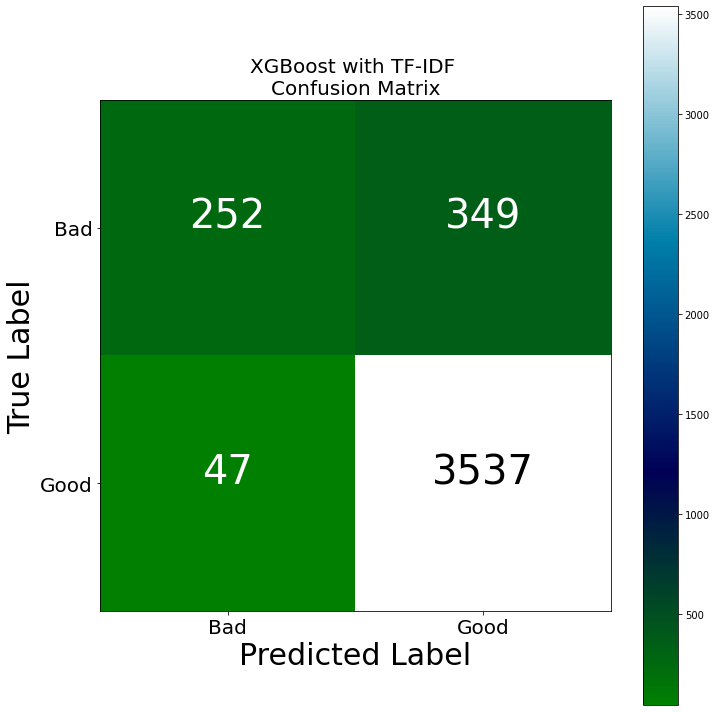

In [128]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

In [133]:
y_pred_proba = model.predict_proba(tfidf_vect_test)
y_pred_proba

array([[0.05086255, 0.94913745],
       [0.41850042, 0.5814996 ],
       [0.02724481, 0.9727552 ],
       ...,
       [0.1458112 , 0.8541888 ],
       [0.00761235, 0.99238765],
       [0.17286986, 0.82713014]], dtype=float32)

74603    1
86839    1
44383    1
25730    0
52972    1
        ..
94446    1
62012    1
78272    1
97108    1
84153    1
Name: rating_class, Length: 4185, dtype: int64
[[0.05086255 0.94913745]
 [0.41850042 0.5814996 ]
 [0.02724481 0.9727552 ]
 ...
 [0.1458112  0.8541888 ]
 [0.00761235 0.99238765]
 [0.17286986 0.82713014]]


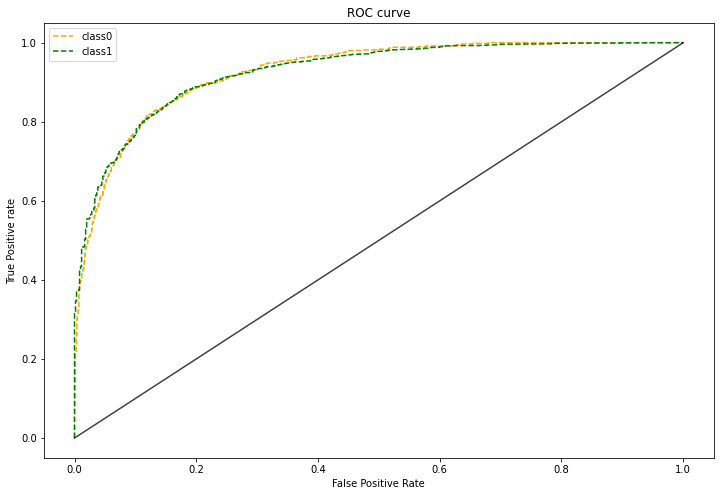

In [134]:
plot_auroc_curve(y_test, y_pred_proba)

In [153]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost'])

In [154]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
TF - IDF   LogReg        0.890562 bad       0.593464  0.755408  0.664714   
                                  good      0.957018  0.913225  0.934609   
                                  average   0.904808  0.890562  0.895850   
           Random Forest 0.885783 bad       0.773333  0.289517  0.421308   
                                  good      0.892172  0.985770  0.936638   
                                  average   0.875106  0.885783  0.862633   
           Naive Bayes   0.881004 bad       0.905512  0.191348  0.315934   
                                  good      0.880237  0.996652  0.934834   
                                  average   0.883866  0.881004  0.845955   
           XGBoost       0.905376 bad       0.842809  0.419301  0.560000   
                                  good      0.910190  0.986886  0.946988   
                                  average   0.900514  0.905376  0.891413   

                                           support  
vectorizer model         accuracy class             
TF - IDF   LogReg        0.890562 bad        601.0  
                                  good      3584.0  
                                  average   4185.0  
           Random Forest 0.885783 bad        601.0  
                                  good      3584.0  
                                  average   4185.0  
           Naive Bayes   0.881004 bad        601.0  
                                  good      3584.0  
                                  average   4185.0  
           XGBoost       0.905376 bad        601.0  
                                  good      3584.0  
                                  average   4185.0

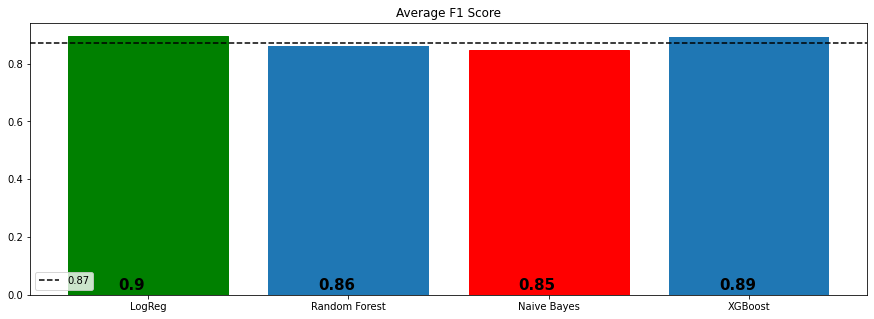

In [137]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

In [138]:
dill.dump_session('Sentiment Analysis.db')